In [10]:
%reload_ext autoreload
%autoreload 2

from ripple_heterogeneity.utils import (
    functions,
    loading,
    compress_repeated_epochs,
    batch_analysis,
    add_new_deep_sup,
    custom_plots
)
from ripple_heterogeneity.replay import replay_fig
from ad_ied.replay import replay_run
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pickle
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
import random
from matplotlib.ticker import AutoMinorLocator

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'D:\github\ad_ied\results'


In [40]:
df = pd.DataFrame()
df["basepath"] = [
    r'X:\AD_sessions\AD_10_sess25\AZ10_210806_sess25',
    r'X:\AD_sessions\AD_10_sess25\AZ15_221102_sess8',
    r'X:\AD_sessions\AD_10_sess25\Naz1_210324_sess5',
    r'X:\AD_sessions\WT_1_sess26\Naz1_210811_sess26'
]
df.to_csv(r"D:\github\ad_ied\data\sessions.csv",index=True)

In [56]:
save_path = r"D:\github\ad_ied\results\replay_v2"
batch_analysis.run(
    df,
    save_path,
    replay_run.run,
    parallel=True,
    skip_if_error=False,
    traj_shuff=1000,
    verbose=True,
    expand_ripple=0
)

100%|██████████| 4/4 [00:00<00:00, 2050.50it/s]


In [42]:
df = replay_run.load_results(save_path,pre_task_post=True,verbose=True)

D:\github\ad_ied\results\replay_v1\X__AD_sessions_AD_10_sess25_AZ10_210806_sess25.pkl
D:\github\ad_ied\results\replay_v1\X__AD_sessions_AD_10_sess25_AZ15_221102_sess8.pkl
D:\github\ad_ied\results\replay_v1\X__AD_sessions_AD_10_sess25_Naz1_210324_sess5.pkl
D:\github\ad_ied\results\replay_v1\X__AD_sessions_WT_1_sess26_Naz1_210811_sess26.pkl


## Inspect decoding quality

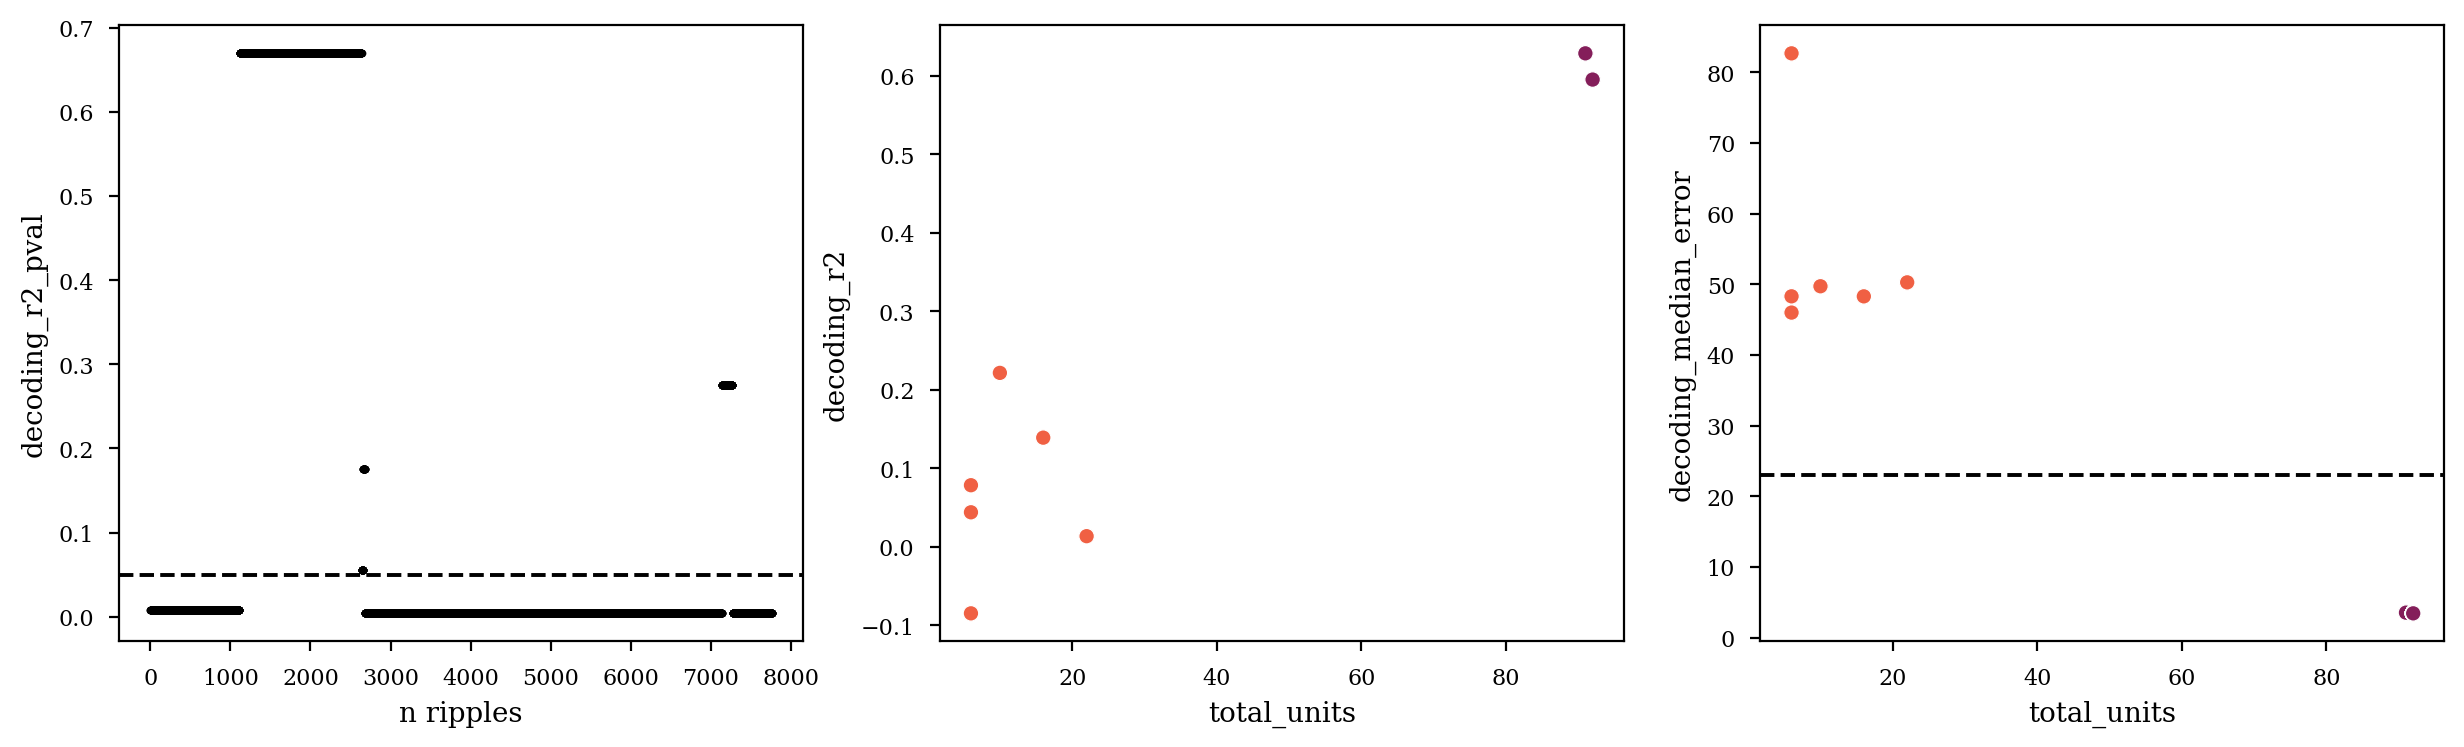

In [43]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].plot(df.decoding_r2_pval, '.k')
axs[0].set_ylabel('decoding_r2_pval')
axs[0].set_xlabel('n ripples')
axs[0].axhline(0.05, color='k', linestyle='--')

sns.scatterplot(x="total_units", y="decoding_r2",
                hue=df.decoding_median_error<23,
                data=df, ax=axs[1], legend=False, palette="rocket_r")

sns.scatterplot(x="total_units", y="decoding_median_error",
                hue=df.decoding_median_error<23,palette="rocket_r",
                data=df, ax=axs[2], legend=False)
# axs[2].legend(bbox_to_anchor=(1.1, 1.05))
axs[2].axhline(23, color='k', linestyle='--')

In [47]:
df.query("decoding_median_error < 20").basepath.unique()

array(['X:\\AD_sessions\\AD_10_sess25\\Naz1_210324_sess5'], dtype=object)

In [44]:
alpha = 0.05
print('n ripples', df.shape[0])
print('pass by col swap', sum(df['score_pval_col_cycle'] < alpha))

print(df[df['score_pval_col_cycle'] < alpha].basepath.value_counts())
print('')
print('pass by time swap', sum(df['score_pval_time_swap'] < alpha))
print(df[df['score_pval_time_swap'] < alpha].basepath.value_counts())
print('')
print('pass by time swap & col swap', sum(
    (df['score_pval_time_swap'] < alpha) & (df['score_pval_col_cycle'] < alpha)))
print(df[(df['score_pval_time_swap'] < alpha) & (
    df['score_pval_col_cycle'] < alpha)].basepath.value_counts())

n ripples 7766
pass by col swap 829
X:\AD_sessions\AD_10_sess25\Naz1_210324_sess5     506
X:\AD_sessions\AD_10_sess25\AZ10_210806_sess25    244
X:\AD_sessions\WT_1_sess26\Naz1_210811_sess26      74
X:\AD_sessions\AD_10_sess25\AZ15_221102_sess8       5
Name: basepath, dtype: int64

pass by time swap 440
X:\AD_sessions\AD_10_sess25\Naz1_210324_sess5     233
X:\AD_sessions\AD_10_sess25\AZ10_210806_sess25    171
X:\AD_sessions\WT_1_sess26\Naz1_210811_sess26      34
X:\AD_sessions\AD_10_sess25\AZ15_221102_sess8       2
Name: basepath, dtype: int64

pass by time swap & col swap 277
X:\AD_sessions\AD_10_sess25\Naz1_210324_sess5     162
X:\AD_sessions\AD_10_sess25\AZ10_210806_sess25     97
X:\AD_sessions\WT_1_sess26\Naz1_210811_sess26      17
X:\AD_sessions\AD_10_sess25\AZ15_221102_sess8       1
Name: basepath, dtype: int64


In [48]:
session = r"D:\github\ad_ied\data\replay_v1\X__AD_sessions_AD_10_sess25_AZ10_210806_sess25.pkl"
session = r"D:\github\ad_ied\data\replay_v1\X__AD_sessions_AD_10_sess25_AZ15_221102_sess8.pkl"
session = r"D:\github\ad_ied\results\replay_v1\X__AD_sessions_AD_10_sess25_Naz1_210324_sess5.pkl"
with open(session, 'rb') as f:
    results = pickle.load(f)


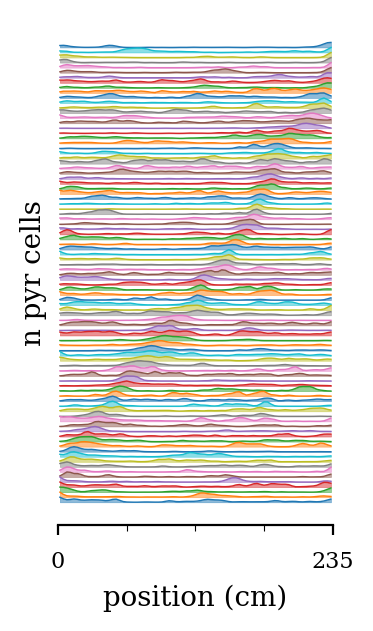

In [53]:
tc = results["right_epochs"]['tc']

w, h = functions.set_size('thesis', fraction=.3, subplots=(3, 1))

with npl.FigureManager(show=True, figsize=(w, h)) as (fig, ax):
    npl.utils.skip_if_no_output(fig)
    ax1 = npl.plot_tuning_curves1D(
        tc.reorder_units(), normalize=True, pad=1, fill=True,alpha=.5)

    leg_lines = ax1.get_lines()
    plt.setp(leg_lines, linewidth=.5)
    ax.set_xlabel('position (cm)')
    ax.set_ylabel('n pyr cells')
    # ax.set_yticks([0,tc.ratemap.shape[0]])
    ax.set_yticks([])
    ax.set_xticks([0, tc.bins.max()])

    ax.xaxis.set_minor_locator(AutoMinorLocator())

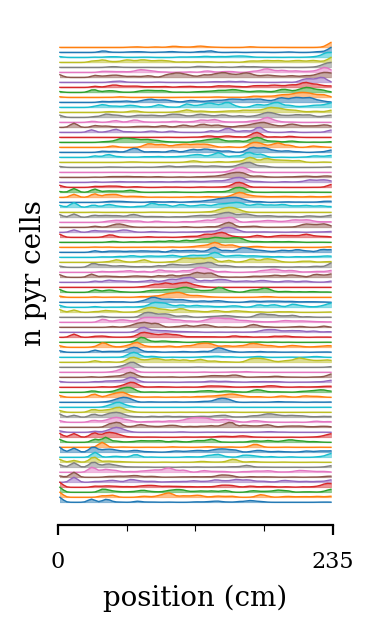

In [52]:
tc = results["left_epochs"]['tc']

w, h = functions.set_size('thesis', fraction=.3, subplots=(3, 1))

with npl.FigureManager(show=True, figsize=(w, h)) as (fig, ax):
    npl.utils.skip_if_no_output(fig)
    ax1 = npl.plot_tuning_curves1D(
        tc.reorder_units(), normalize=True, pad=1, fill=True,alpha=.5)

    leg_lines = ax1.get_lines()
    plt.setp(leg_lines, linewidth=.5)
    ax.set_xlabel('position (cm)')
    ax.set_ylabel('n pyr cells')
    # ax.set_yticks([0,tc.ratemap.shape[0]])
    ax.set_yticks([])
    ax.set_xticks([0, tc.bins.max()])

    ax.xaxis.set_minor_locator(AutoMinorLocator())

In [ ]:
def plot_the_replays(curr_results, dir_epoch, replay_type):
    try:
        basepath = curr_results[dir_epoch]["session"]
    except:
        return
    animal_name = loading.get_animal_id(basepath)
    basename = os.path.basename(basepath)

    curr_results[dir_epoch]["df"].ev_label.replace({np.nan: "natural"}, inplace=True)

    # idx = np.where(
    #     (curr_results[dir_epoch]["df"].score_pval_col_cycle < 0.05)
    #     & (curr_results[dir_epoch]["df"].replay_type == replay_type)
    # )[0]
    idx = np.where(
        (curr_results[dir_epoch]["df"].replay_type == replay_type)
    )[0]

    # if curr_results[dir_epoch]["decoding_r2_pval"] > 0.05:
    #     idx = []

    if len(idx) > 0:
        ax, fig = replay_fig.plot_all_replay(
            curr_results[dir_epoch]["bst_placecells"][idx],
            curr_results[dir_epoch]["sta_placecells"],
            curr_results[dir_epoch]["tc"],
            curr_results[dir_epoch]["tc"],
            vmax=0.1,
        )
        fig.savefig(
            os.path.join(
                r"D:\github\ad_ied\results\replay_examples",
                basename
                + "_"
                + animal_name
                + "_"
                + dir_epoch
                + "_"
                + replay_type
                + ".jpeg",
            ),
            dpi=300,
            bbox_inches="tight",
        )
        # plt.show(block=False)
        plt.close('all')


sessions = glob.glob(save_path + os.sep + "*.pkl")
for session in sessions:
    with open(session, "rb") as f:
        curr_results = pickle.load(f)

    if curr_results is None:
        continue
    for traj in curr_results.keys():
        plot_the_replays(curr_results, traj, "forward")
        plot_the_replays(curr_results, traj, "reverse")

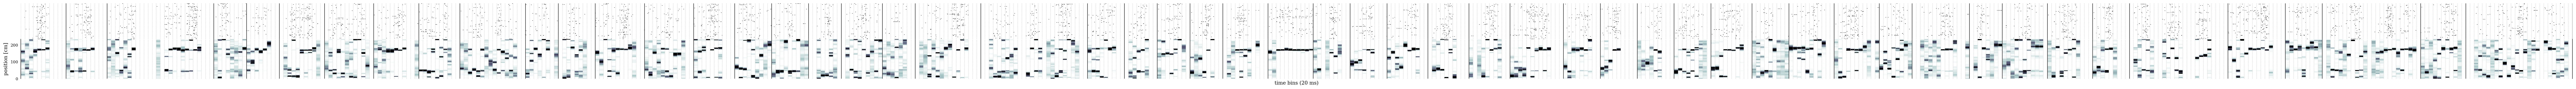

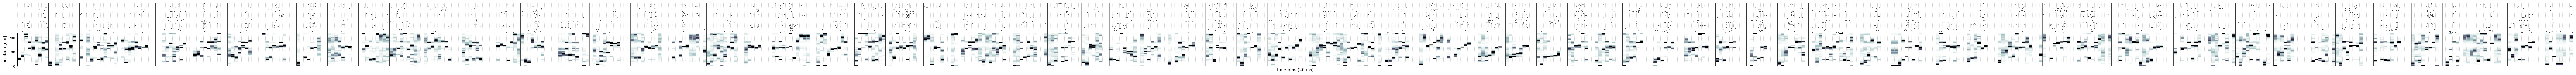

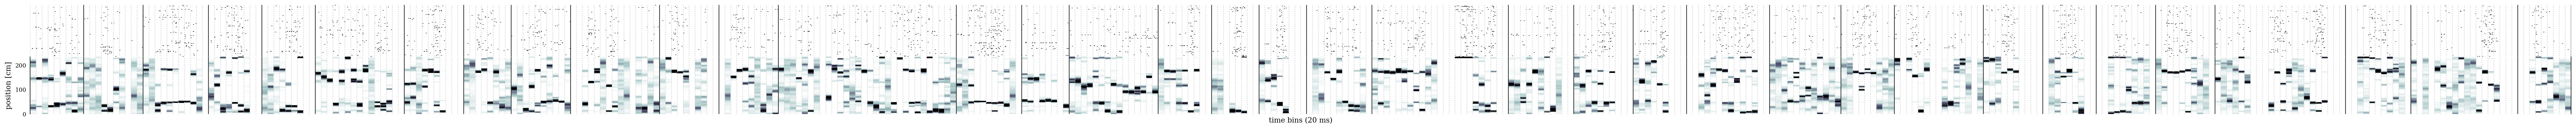

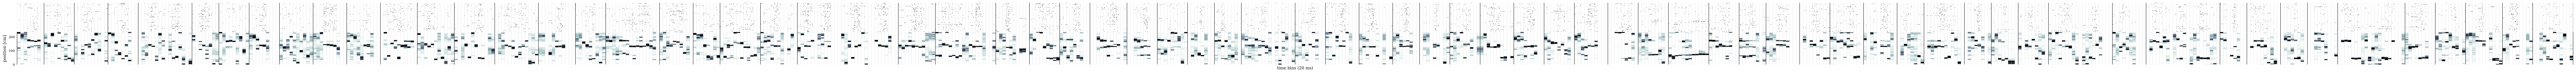

In [55]:
forward_path = os.path.join(fig_save_path, 'replay_examples', 'forward')
reverse_path = os.path.join(fig_save_path, 'replay_examples', 'reverse')

if not os.path.isdir(forward_path):
    os.mkdir(forward_path)
if not os.path.isdir(reverse_path):
    os.mkdir(reverse_path)

sessions = glob.glob(save_path + os.sep + '*.pkl')
for session in sessions:
    with open(session, 'rb') as f:
        results = pickle.load(f)

    if results is None:
        continue
    
    basepath = results['right_epochs']['session']
    animal_name = loading.get_animal_id(basepath)
    basename = os.path.basename(basepath)
    idx = np.where((results['right_epochs']['df'].score_pval_time_swap < 0.05) &
                    (results['right_epochs']['df'].replay_type == 'forward'))[0]

    if (results['right_epochs']["decoding_r2_pval"] > 0.05) | (results['right_epochs']["decoding_median_error"] > 30):
        idx = []
            
    if len(idx) > 0:
        ax, fig = replay_fig.plot_all_replay(results['right_epochs']['bst_placecells'][idx],
                                                results['right_epochs']['sta_placecells'],
                                                results['right_epochs']['tc'],
                                                results['right_epochs']['tc'],
                                                vmax=.1)
        fig.savefig(os.path.join(fig_save_path, 'replay_examples', forward_path,
                    basename+'_'+animal_name+'_.jpeg'), dpi=300, bbox_inches='tight')
        plt.close(fig)

    idx = np.where((results['left_epochs']['df'].score_pval_time_swap < 0.05) &
                    (results['left_epochs']['df'].replay_type == 'forward'))[0]

    if (results['left_epochs']["decoding_r2_pval"] > 0.05) | (results['left_epochs']["decoding_median_error"] > 30):
        idx = []
    if len(idx) > 0:
        ax, fig = replay_fig.plot_all_replay(results['left_epochs']['bst_placecells'][idx],
                                                results['left_epochs']['sta_placecells'],
                                                results['left_epochs']['tc'],
                                                results['left_epochs']['tc'],
                                                vmax=.1)
        fig.savefig(os.path.join(fig_save_path, 'replay_examples', forward_path,
                    basename+'_'+animal_name+'1_.jpeg'), dpi=300, bbox_inches='tight')
        plt.close(fig)

    idx = np.where((results['right_epochs']['df'].score_pval_time_swap < 0.05) &
                    (results['right_epochs']['df'].replay_type == 'reverse'))[0]
    if (results['right_epochs']["decoding_r2_pval"] > 0.05) | (results['right_epochs']["decoding_median_error"] > 30):
        idx = []               
    if len(idx) > 0:
        ax, fig = replay_fig.plot_all_replay(results['right_epochs']['bst_placecells'][idx],
                                                results['right_epochs']['sta_placecells'],
                                                results['right_epochs']['tc'],
                                                results['right_epochs']['tc'],
                                                vmax=.1)
        fig.savefig(os.path.join(fig_save_path, 'replay_examples', reverse_path,
                    basename+'_'+animal_name+'_.jpeg'), dpi=300, bbox_inches='tight')
        plt.close(fig)

    idx = np.where((results['left_epochs']['df'].score_pval_time_swap < 0.05) &
                    (results['left_epochs']['df'].replay_type == 'reverse'))[0]
    if (results['left_epochs']["decoding_r2_pval"] > 0.05) | (results['left_epochs']["decoding_median_error"] > 30):
        idx = []                
    if len(idx) > 0:
        ax, fig = replay_fig.plot_all_replay(results['left_epochs']['bst_placecells'][idx],
                                                results['left_epochs']['sta_placecells'],
                                                results['left_epochs']['tc'],
                                                results['left_epochs']['tc'],
                                                vmax=.1)
        fig.savefig(os.path.join(fig_save_path, 'replay_examples', reverse_path,
                    basename+'_'+animal_name+'1_.jpeg'), dpi=300, bbox_inches='tight')
        plt.close(fig)